<a href="https://colab.research.google.com/github/KamalAsh0ur/NTI/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 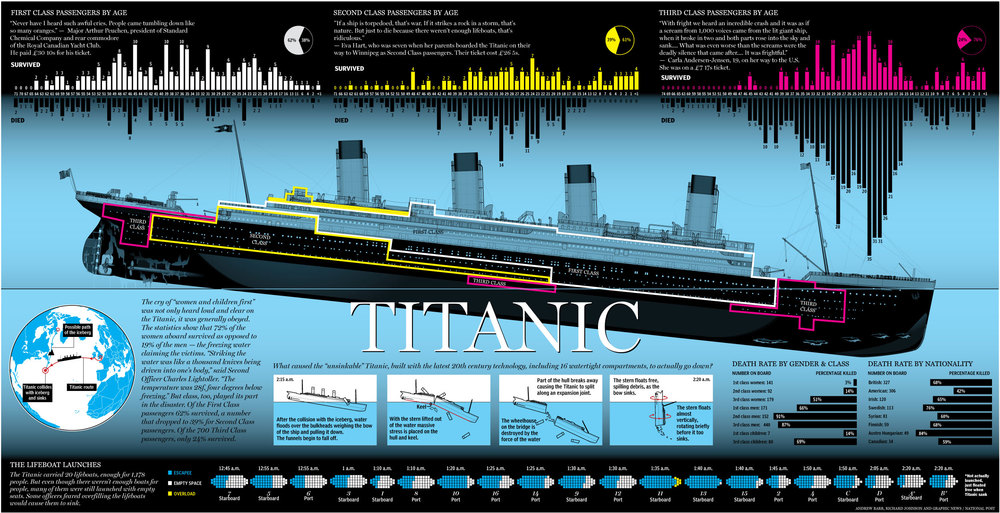

# **Titanic Investigation Analysis**

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('titanic.csv')

# **Pre-processing**

In [ ]:

df.drop('deck',axis=1,inplace=True)

In [ ]:
df


survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male  embark_town alive  alone  
0      man        True  Southampton    no  False  
1    woman       False    Cherbourg   yes  False  
2    woman       False  Southampton   yes   True  
3    woman       False  Southampton   yes  False  
4      man        True  Southampton    no   True  
..     ...         ...          ...   ...    ...  
886    man        True  Southampton    no   True  
887  woman       False  Southampton   yes   True  
888  woman       False  Southampton    no  False  
889    man        True    Cherbourg   yes   True  
890    man        True   Queenstown    no   True  

[891 rows x 14 columns]

# **Detecting Null's**

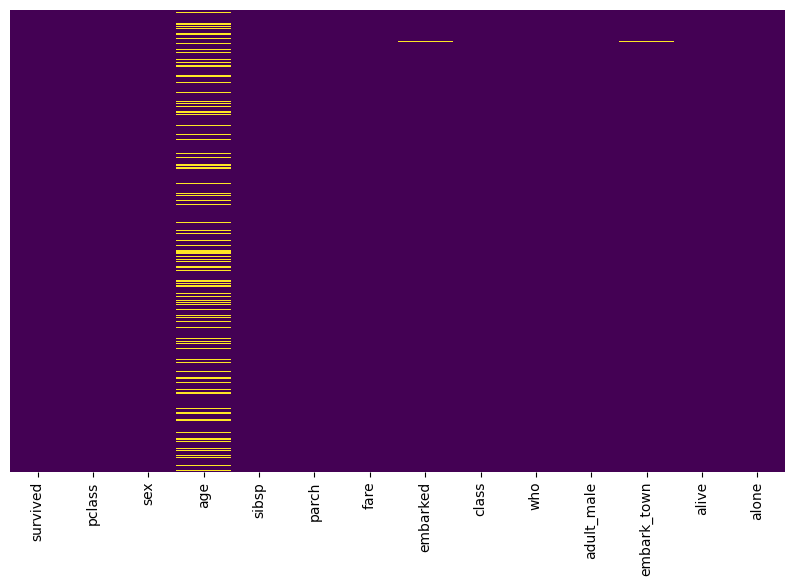

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()


# Too Mutch Null's in "age"
**Strategies** for Imputation
Create a Missing Indicator:
Add a binary column to signal missingness, which can capture hidden patterns.

In [ ]:
df['age_missing'] = df['age'].isnull().astype(int)

In [ ]:
non_null_age = df['age'].dropna()
null_age_mask = df['age'].isnull()
df.loc[null_age_mask, 'age'] = np.random.choice(non_null_age, size=null_age_mask.sum(), replace=True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

X = df[['age', 'fare']]
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Split the data

imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

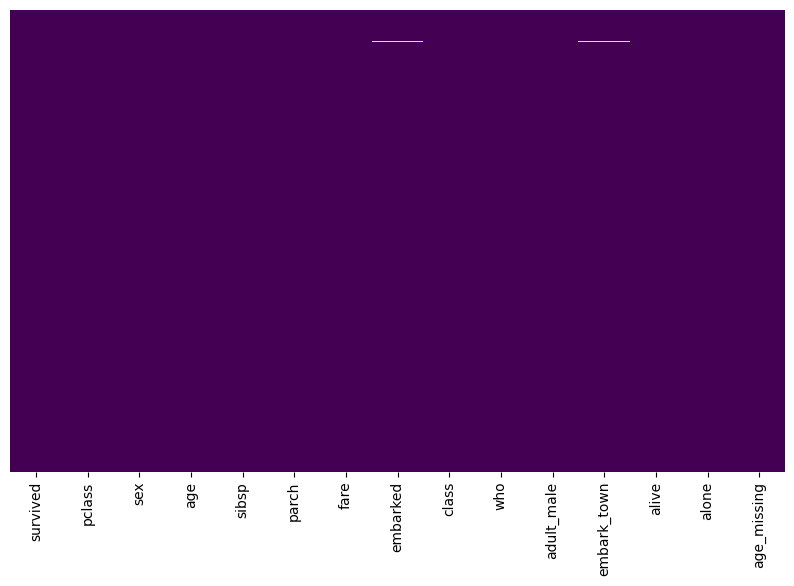

In [ ]:

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [ ]:
df.dropna(inplace=True)

# **Distribution Progiling**
**--Outliers Detection**

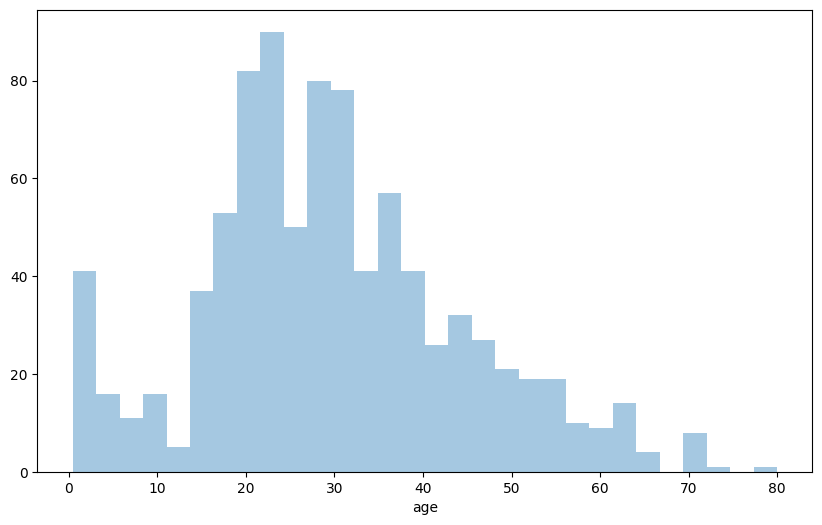

In [ ]:

plt.figure(figsize=(10,6))
sns.distplot(df['age'],kde=False,bins=30)
plt.show()

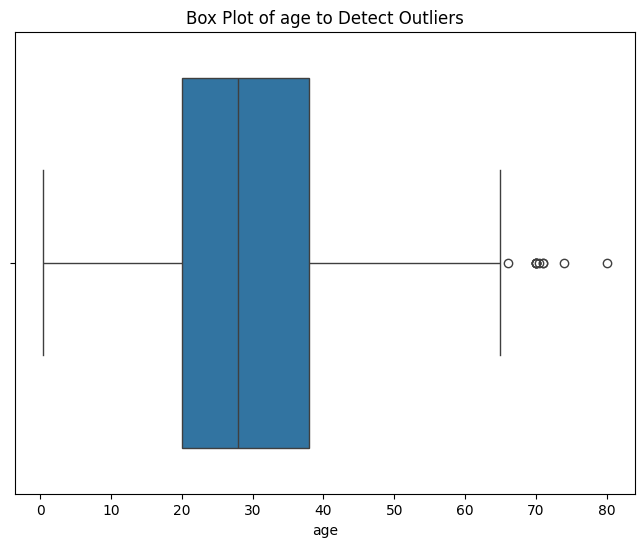

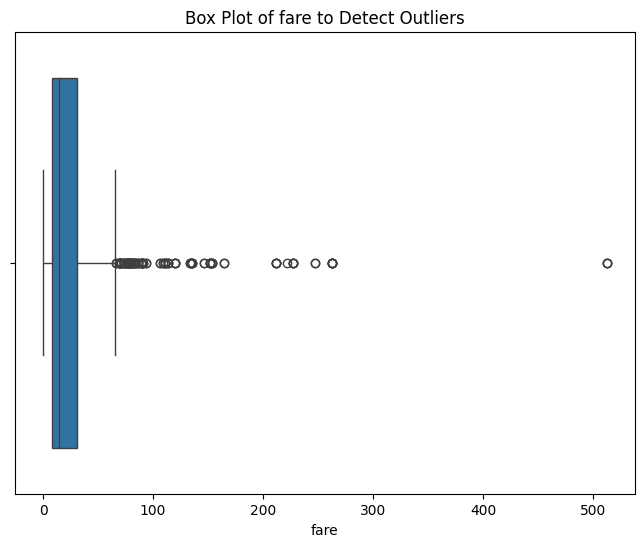

In [ ]:

import matplotlib.pyplot as plt

def detect_outliers(df, column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column} to Detect Outliers')
    plt.show()

detect_outliers(df, 'age')
detect_outliers(df, 'fare')

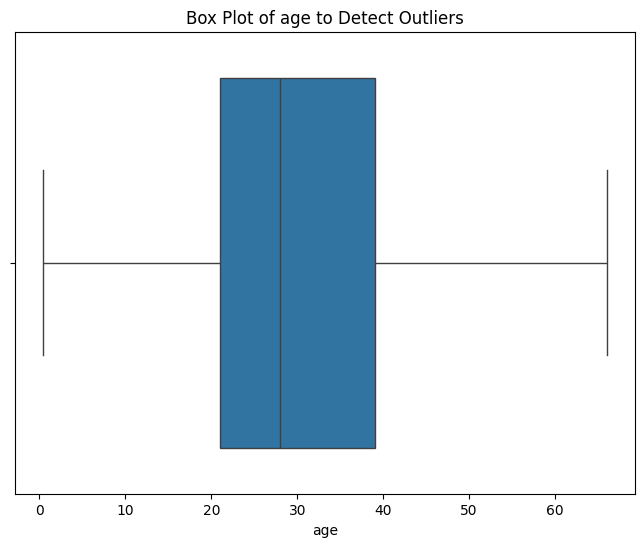

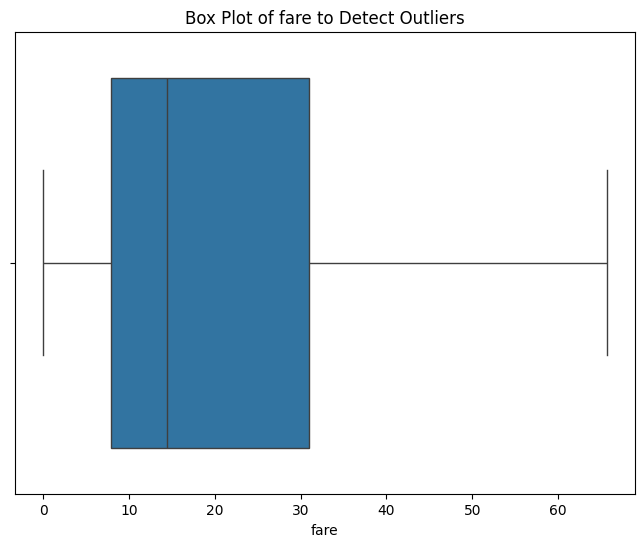

In [ ]:

import matplotlib.pyplot as plt

def detect_outliers(df, column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column} to Detect Outliers')
    plt.show()

detect_outliers(df, 'age')
detect_outliers(df, 'fare')

# **Visualization** ðŸ’¹

In [74]:
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go


df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))
df['age_missing'] = df['age'].isnull().astype(int)

df['family_size'] = df['sibsp'] + df['parch'] + 1

df['age_group'] = pd.cut(df['age'],
                         bins=[0, 12, 18, 30, 50, 100],
                         labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

# Calculate KPIs
survival_rate = df['survived'].mean()
avg_age = df['age'].mean()
avg_fare = df['fare'].mean()
class_distribution = df['pclass'].value_counts(normalize=True)
family_size_dist = df['family_size'].value_counts().head(5)
embarked_dist = df['embark_town'].value_counts()

fig1 = px.pie(values=[survival_rate, 1-survival_rate],
             names=['Survived', 'Died'],
             title='Overall Survival Rate')

fig2 = px.bar(df['pclass'].value_counts().reset_index(),
             x='pclass', y='count',
             title='Passenger Class Distribution',
             labels={'pclass': 'Class', 'count': 'Passengers'})

fig3 = px.histogram(df, x='age', color='survived',
                   title='Age Distribution by Survival',
                   nbins=30, barmode='overlay')

fig4 = px.box(df, x='pclass', y='fare', color='survived',
             title='Fare Distribution by Class and Survival')

fig5 = px.sunburst(df, path=['sex', 'age_group', 'survived'],
                  title='Survival Distribution by Gender and Age Group')

fig6 = px.imshow(df.corr(numeric_only=True),
                text_auto=True,
                title='Correlation Matrix')

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Titanic Disaster Dashboard", style={'text-align': 'center'}),

    html.Div([
        html.Div([
            dcc.Graph(figure=fig1, style={'height': '400px'})
        ], className='six columns'),

        html.Div([
            dcc.Graph(figure=fig2, style={'height': '400px'})
        ], className='six columns')
    ], className='row'),

    html.Div([
        dcc.Graph(figure=fig3, style={'height': '400px'})
    ], className='row'),

    html.Div([
        html.Div([
            dcc.Graph(figure=fig4, style={'height': '400px'})
        ], className='six columns'),

        html.Div([
            dcc.Graph(figure=fig5, style={'height': '400px'})
        ], className='six columns')
    ], className='row'),

    html.Div([
        dcc.Graph(figure=fig6, style={'height': '600px'})
    ], className='row'),

    html.Div([
        html.H3("Key Insights:"),
        html.Ul([
            html.Li(f"Overall survival rate: {survival_rate:.1%}"),
            html.Li(f"Average passenger age: {avg_age:.1f} years"),
            html.Li(f"Average fare: ${avg_fare:.2f}"),
            html.Li("1st class passengers had significantly higher survival rates"),
            html.Li("Women and children had priority in lifeboats"),
            html.Li("Higher fare classes showed better survival chances")
        ])
    ])
])

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>